In [20]:
import decimal
from collections import defaultdict
import matplotlib
import numpy as np
import itertools
import os
import pandas as pd
import datetime
from joblib import dump
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import glob
import pdb
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_curve, auc
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0, '../../scripts/modeling_toolbox/')
sys.path.insert(0, '../../scripts/asset_processor/')
import utils
from video_asset_processor import VideoAssetProcessor

%matplotlib notebook
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize']=[10,6]
pd.options.display.width = 0
pd.set_option('display.max_columns', None)

In [21]:
%matplotlib notebook

In [22]:
FEATURES_UL = ['size_dimension_ratio',
               'temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]

FEATURES_SL = ['temporal_dct-mean',
               'temporal_gaussian_mse-mean',
               'temporal_gaussian_difference-mean',
               'temporal_threshold_gaussian_difference-mean'
               ]
FEATURES_QOE = ['temporal_dct-mean',
            'temporal_gaussian_mse-mean',
            'temporal_gaussian_difference-mean',
            'temporal_threshold_gaussian_difference-mean'
            ]
FEATURES_META = ['cat_r_pred','cat_cl_pred','ocsvm_pred']
METRICS_QOE = ['temporal_ssim-mean']
FULL_FEATURES = list(set(FEATURES_UL+FEATURES_SL+FEATURES_QOE+METRICS_QOE))
# Target variable, 1 represents Tamper, 0 is correct rendition
TARGET = ['target']

train_fraction = 0.85

In [23]:
# read data
data = utils.load_data('../../../data/data-large.csv')
len_before = len(data)

In [24]:
# drop all columns without some of the features
data.dropna(axis=0, subset=FEATURES_SL+FEATURES_UL+FEATURES_QOE+METRICS_QOE, inplace=True)
print(f'Removed {len_before - len(data)} NA rows')

Removed 15192 NA rows


In [25]:
# split test and train making sure source and its renditions are not split
np.random.seed(1337)
master_ids = data.master_id.unique()
train_master_ids = np.random.choice(master_ids, int(train_fraction*master_ids.shape[0]), replace=False)
train_idx = np.isin(data.master_id, train_master_ids)
train_data = data[train_idx]
test_data = data[~data.index.isin(train_data.index)]
y_test = test_data['target']
y_train = train_data['target']
# assert not np.any(np.isin(train_data.master_id, test_data.master_id))

In [26]:
# renditions by type
print('Test data top rendition types:')
test_data.groupby('rendition').rendition.count().sort_values().tail(15)

Test data top rendition types:


rendition
1080p_rotate_90_clockwise    529
360p                         529
144p_low_bitrate_4           529
1080p_low_bitrate_4          529
360p_black_and_white         529
360p_low_bitrate_4           529
360p_rotate_90_clockwise     529
360p_vignette                529
360p_watermark               529
480p                         529
480p_black_and_white         529
480p_low_bitrate_4           529
480p_rotate_90_clockwise     529
480p_vignette                529
144p                         529
Name: rendition, dtype: int64

In [27]:
# class balance, 1 is tampered rendition, 0 is accurate rendition
print('Test data class balance:')
test_data.groupby('target').target.count()

Test data class balance:


target
0     2788
1    25915
Name: target, dtype: int64

In [28]:
# test renditions by type
print('Test data FPS renditions count:')
test_data[test_data.rendition.str.contains('fps')]['target']

Test data FPS renditions count:


id
1080p_24-30fps/33S9MmkEJzc.mp4                                      0
1080p_24-30fps/AQKale-lyaA.mp4                                      0
1080p_24-30fps/DlknpJcn1QM.mp4                                      0
1080p_24-30fps/Hw161KRfA5I.mp4                                      0
1080p_50-30fps/GDPLXneWvgc_60.mp4                                   0
144p_flip_vertical_50-30fps/olkMNKt5JZ0_60.mp4                      1
1080p_watermark-856x856_50-60fps/olkMNKt5JZ0_60.mp4                 1
1080p_vignette_50-24fps/vaOYahFWBNA_60.mp4                          1
144p_black_and_white_24-60fps_gpu/YRXsFtqOeAI.mp4                   1
1080p_flip_horizontal_24-30fps/5bXqi7ReuVU.mp4                      1
144p_24-60fps_gpu/7n3zr8jIaRY.mp4                                   0
1080p_black_and_white_25-30fps_gpu/vYwhOc3LxpM.mp4                  1
144p_rotate_90_clockwise_25-60fps_gpu/vYwhOc3LxpM.mp4               1
1080p_watermark_25-30fps/r5AKa5aVUvE.mp4                            1
1080p_vignette_24

In [29]:
### OCSVM MODEL
# fit outlier detector to tampered videos as a bigger class
x_train_ul = np.asarray(train_data[FEATURES_UL][train_data.target==0])
x_test_ul = np.asarray(test_data[FEATURES_UL])
# scale the data
scaler = StandardScaler()
x_train_ul = scaler.fit_transform(x_train_ul)
x_test_ul = scaler.transform(x_test_ul)
# fit the model
oc_svm = svm.OneClassSVM(kernel='rbf', gamma=0.3, nu=0.001, cache_size=5000)
oc_svm.fit(x_train_ul)
def ocsvm_score_converter(score):
    return 1-1/(1+np.exp(-score))
# get predictions on test and convert them with sigmoid function to (0,1) interval
test_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(x_test_ul))
# add predictions to train data
train_data['ocsvm_pred'] = ocsvm_score_converter(oc_svm.decision_function(np.asarray(train_data[FEATURES_UL])))
test_data['ocsvm_pred_label'] = (-oc_svm.predict(x_test_ul)+1)/2
# dump scaler and model
dump(scaler, '../output/models/OCSVM_StandardScaler_v2.joblib')
dump(oc_svm, '../output/models/OCSVM_v2.joblib')

['../output/models/OCSVM_v2.joblib']

In [48]:
### CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_binary = CatBoostClassifier(**cb_params)
# Fit model
cat_x_train = np.asarray(train_data[FEATURES_SL])
catboost_binary.fit(cat_x_train, train_data['target'], cat_features)
cat_x_test = np.asarray(test_data[FEATURES_SL])
test_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_test)[:,1]
test_data['cat_cl_y_pred_label'] = catboost_binary.predict(cat_x_test)
# add predictions to train data
train_data['cat_cl_pred'] = catboost_binary.predict_proba(cat_x_train)[:,1]
catboost_binary.save_model('../output/models/CB_Binary_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)


0:	learn: 0.5930158	total: 13.4ms	remaining: 6.68s
1:	learn: 0.5041125	total: 24.9ms	remaining: 6.19s
2:	learn: 0.4388084	total: 36.4ms	remaining: 6.03s
3:	learn: 0.3923794	total: 50.6ms	remaining: 6.27s
4:	learn: 0.3529899	total: 63.6ms	remaining: 6.3s
5:	learn: 0.3163119	total: 77.1ms	remaining: 6.35s
6:	learn: 0.2917295	total: 90.1ms	remaining: 6.35s
7:	learn: 0.2714059	total: 103ms	remaining: 6.34s
8:	learn: 0.2569235	total: 117ms	remaining: 6.39s
9:	learn: 0.2453469	total: 131ms	remaining: 6.43s
10:	learn: 0.2361112	total: 143ms	remaining: 6.36s
11:	learn: 0.2236638	total: 155ms	remaining: 6.3s
12:	learn: 0.2168825	total: 169ms	remaining: 6.32s
13:	learn: 0.2114802	total: 181ms	remaining: 6.28s
14:	learn: 0.2049919	total: 196ms	remaining: 6.34s
15:	learn: 0.2002418	total: 212ms	remaining: 6.41s
16:	learn: 0.1952313	total: 225ms	remaining: 6.39s
17:	learn: 0.1924015	total: 250ms	remaining: 6.71s
18:	learn: 0.1898840	total: 270ms	remaining: 6.82s
19:	learn: 0.1879184	total: 283ms	re

162:	learn: 0.1481228	total: 2.95s	remaining: 6.1s
163:	learn: 0.1480734	total: 2.97s	remaining: 6.08s
164:	learn: 0.1480301	total: 3s	remaining: 6.09s
165:	learn: 0.1479628	total: 3.03s	remaining: 6.09s
166:	learn: 0.1479211	total: 3.07s	remaining: 6.11s
167:	learn: 0.1478466	total: 3.09s	remaining: 6.11s
168:	learn: 0.1478415	total: 3.12s	remaining: 6.1s
169:	learn: 0.1478255	total: 3.14s	remaining: 6.09s
170:	learn: 0.1477736	total: 3.17s	remaining: 6.1s
171:	learn: 0.1477305	total: 3.2s	remaining: 6.1s
172:	learn: 0.1477140	total: 3.22s	remaining: 6.09s
173:	learn: 0.1476973	total: 3.25s	remaining: 6.09s
174:	learn: 0.1476591	total: 3.27s	remaining: 6.07s
175:	learn: 0.1476383	total: 3.31s	remaining: 6.1s
176:	learn: 0.1476187	total: 3.34s	remaining: 6.1s
177:	learn: 0.1475885	total: 3.38s	remaining: 6.11s
178:	learn: 0.1475395	total: 3.41s	remaining: 6.12s
179:	learn: 0.1475201	total: 3.45s	remaining: 6.13s
180:	learn: 0.1474706	total: 3.48s	remaining: 6.14s
181:	learn: 0.1474466	

329:	learn: 0.1435541	total: 6.1s	remaining: 3.14s
330:	learn: 0.1435411	total: 6.12s	remaining: 3.13s
331:	learn: 0.1435246	total: 6.14s	remaining: 3.11s
332:	learn: 0.1434878	total: 6.15s	remaining: 3.08s
333:	learn: 0.1434713	total: 6.17s	remaining: 3.06s
334:	learn: 0.1434420	total: 6.18s	remaining: 3.04s
335:	learn: 0.1434059	total: 6.2s	remaining: 3.03s
336:	learn: 0.1433941	total: 6.21s	remaining: 3.01s
337:	learn: 0.1433688	total: 6.23s	remaining: 2.99s
338:	learn: 0.1433532	total: 6.25s	remaining: 2.97s
339:	learn: 0.1433419	total: 6.26s	remaining: 2.95s
340:	learn: 0.1433120	total: 6.28s	remaining: 2.93s
341:	learn: 0.1432923	total: 6.29s	remaining: 2.91s
342:	learn: 0.1432810	total: 6.31s	remaining: 2.89s
343:	learn: 0.1432720	total: 6.33s	remaining: 2.87s
344:	learn: 0.1432532	total: 6.34s	remaining: 2.85s
345:	learn: 0.1432372	total: 6.36s	remaining: 2.83s
346:	learn: 0.1432197	total: 6.37s	remaining: 2.81s
347:	learn: 0.1431976	total: 6.39s	remaining: 2.79s
348:	learn: 0.

488:	learn: 0.1403124	total: 8.78s	remaining: 198ms
489:	learn: 0.1402968	total: 8.8s	remaining: 180ms
490:	learn: 0.1402876	total: 8.82s	remaining: 162ms
491:	learn: 0.1402746	total: 8.83s	remaining: 144ms
492:	learn: 0.1402640	total: 8.85s	remaining: 126ms
493:	learn: 0.1402451	total: 8.86s	remaining: 108ms
494:	learn: 0.1402349	total: 8.88s	remaining: 89.7ms
495:	learn: 0.1402259	total: 8.9s	remaining: 71.8ms
496:	learn: 0.1402061	total: 8.91s	remaining: 53.8ms
497:	learn: 0.1401871	total: 8.93s	remaining: 35.9ms
498:	learn: 0.1401594	total: 8.95s	remaining: 17.9ms
499:	learn: 0.1401385	total: 8.96s	remaining: 0us


In [33]:
### CATBOOST QOE REGRESSOR
categorical_features_indices = []

train_pool = Pool(data=train_data[FEATURES_QOE],
                  label=train_data[METRICS_QOE],
                  cat_features=categorical_features_indices)

loss_funct = 'MAE'
cb_params = {'depth':6,
             'num_trees':100,
             'l2_leaf_reg':5,
             'learning_rate':0.05,
             'loss_function':loss_funct}
model_catboost_regressor = CatBoostRegressor(**cb_params)

#Train the model
print('Training QoE model:')
model_catboost_regressor.fit(train_pool)
train_data['cat_r_pred'] = model_catboost_regressor.predict(train_data[FEATURES_QOE])
test_data['cat_r_pred'] = model_catboost_regressor.predict(test_data[FEATURES_QOE])

Training QoE model:
0:	learn: 0.1412403	total: 14.3ms	remaining: 1.42s
1:	learn: 0.1362346	total: 28.1ms	remaining: 1.38s
2:	learn: 0.1318772	total: 42ms	remaining: 1.36s
3:	learn: 0.1274311	total: 56.8ms	remaining: 1.36s
4:	learn: 0.1233922	total: 71.6ms	remaining: 1.36s
5:	learn: 0.1198512	total: 85.4ms	remaining: 1.34s
6:	learn: 0.1162976	total: 99.8ms	remaining: 1.32s
7:	learn: 0.1129463	total: 115ms	remaining: 1.32s
8:	learn: 0.1098108	total: 133ms	remaining: 1.35s
9:	learn: 0.1068991	total: 157ms	remaining: 1.42s
10:	learn: 0.1043486	total: 174ms	remaining: 1.41s
11:	learn: 0.1019649	total: 188ms	remaining: 1.38s
12:	learn: 0.0995301	total: 202ms	remaining: 1.35s
13:	learn: 0.0972355	total: 216ms	remaining: 1.33s
14:	learn: 0.0950324	total: 230ms	remaining: 1.3s
15:	learn: 0.0930981	total: 245ms	remaining: 1.28s
16:	learn: 0.0911988	total: 259ms	remaining: 1.26s
17:	learn: 0.0893876	total: 274ms	remaining: 1.25s
18:	learn: 0.0877972	total: 288ms	remaining: 1.23s
19:	learn: 0.0862

In [34]:
### META MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_meta = CatBoostClassifier(**cb_params)
# Fit model
meta_x_train = np.asarray(train_data[FEATURES_META])
catboost_meta.fit(meta_x_train, train_data['target'], cat_features)
meta_x_test = np.asarray(test_data[FEATURES_META])
meta_y_test_pred = catboost_meta.predict_proba(meta_x_test)[:,1]
test_data['meta_y_pred'] = catboost_meta.predict_proba(meta_x_test)[:,1]
catboost_meta.save_model('../output/models/CB_Meta_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)

0:	learn: 0.6005825	total: 10.8ms	remaining: 5.37s
1:	learn: 0.4889677	total: 23.6ms	remaining: 5.87s
2:	learn: 0.4243138	total: 36.4ms	remaining: 6.02s
3:	learn: 0.3691059	total: 49.2ms	remaining: 6.1s
4:	learn: 0.3276889	total: 61ms	remaining: 6.04s
5:	learn: 0.2963854	total: 72.8ms	remaining: 5.99s
6:	learn: 0.2726511	total: 86.2ms	remaining: 6.07s
7:	learn: 0.2475172	total: 98.6ms	remaining: 6.06s
8:	learn: 0.2323279	total: 110ms	remaining: 6s
9:	learn: 0.2173902	total: 123ms	remaining: 6.04s
10:	learn: 0.2080011	total: 136ms	remaining: 6.05s
11:	learn: 0.1960778	total: 149ms	remaining: 6.06s
12:	learn: 0.1905927	total: 161ms	remaining: 6.05s
13:	learn: 0.1837226	total: 175ms	remaining: 6.07s
14:	learn: 0.1795592	total: 189ms	remaining: 6.11s
15:	learn: 0.1762643	total: 202ms	remaining: 6.1s
16:	learn: 0.1713641	total: 227ms	remaining: 6.46s
17:	learn: 0.1677462	total: 247ms	remaining: 6.6s
18:	learn: 0.1641830	total: 258ms	remaining: 6.53s
19:	learn: 0.1616936	total: 270ms	remaini

168:	learn: 0.1386877	total: 2.81s	remaining: 5.51s
169:	learn: 0.1386814	total: 2.83s	remaining: 5.49s
170:	learn: 0.1386784	total: 2.85s	remaining: 5.48s
171:	learn: 0.1386770	total: 2.86s	remaining: 5.45s
172:	learn: 0.1386741	total: 2.87s	remaining: 5.43s
173:	learn: 0.1386714	total: 2.89s	remaining: 5.42s
174:	learn: 0.1386641	total: 2.91s	remaining: 5.4s
175:	learn: 0.1386594	total: 2.92s	remaining: 5.38s
176:	learn: 0.1386578	total: 2.93s	remaining: 5.35s
177:	learn: 0.1386544	total: 2.95s	remaining: 5.33s
178:	learn: 0.1386520	total: 2.97s	remaining: 5.32s
179:	learn: 0.1386504	total: 2.98s	remaining: 5.29s
180:	learn: 0.1386448	total: 3s	remaining: 5.28s
181:	learn: 0.1386428	total: 3.01s	remaining: 5.25s
182:	learn: 0.1386354	total: 3.03s	remaining: 5.24s
183:	learn: 0.1386288	total: 3.04s	remaining: 5.22s
184:	learn: 0.1386272	total: 3.05s	remaining: 5.2s
185:	learn: 0.1386256	total: 3.07s	remaining: 5.18s
186:	learn: 0.1386230	total: 3.08s	remaining: 5.16s
187:	learn: 0.138

330:	learn: 0.1379996	total: 5.52s	remaining: 2.82s
331:	learn: 0.1379940	total: 5.54s	remaining: 2.81s
332:	learn: 0.1379898	total: 5.56s	remaining: 2.79s
333:	learn: 0.1379821	total: 5.57s	remaining: 2.77s
334:	learn: 0.1379773	total: 5.59s	remaining: 2.75s
335:	learn: 0.1379701	total: 5.6s	remaining: 2.73s
336:	learn: 0.1379656	total: 5.62s	remaining: 2.72s
337:	learn: 0.1379646	total: 5.63s	remaining: 2.7s
338:	learn: 0.1379578	total: 5.65s	remaining: 2.68s
339:	learn: 0.1379508	total: 5.66s	remaining: 2.66s
340:	learn: 0.1379470	total: 5.68s	remaining: 2.65s
341:	learn: 0.1379405	total: 5.69s	remaining: 2.63s
342:	learn: 0.1379340	total: 5.71s	remaining: 2.61s
343:	learn: 0.1379318	total: 5.72s	remaining: 2.6s
344:	learn: 0.1379253	total: 5.74s	remaining: 2.58s
345:	learn: 0.1379198	total: 5.76s	remaining: 2.56s
346:	learn: 0.1379137	total: 5.78s	remaining: 2.55s
347:	learn: 0.1379105	total: 5.79s	remaining: 2.53s
348:	learn: 0.1379046	total: 5.81s	remaining: 2.51s
349:	learn: 0.1

In [35]:
### FULL FEATURE CATBOOST MODEL
cat_features = []
# Initialize CatBoostClassifier
cb_params = dict(iterations=500,
                 learning_rate=0.05,
                 depth=6)
catboost_full = CatBoostClassifier(**cb_params)
# Fit model
full_x_train = np.asarray(train_data[FULL_FEATURES])
catboost_full.fit(full_x_train, train_data['target'], cat_features)
# estimate optimal threshold to minimize FP rate
full_y_train_pred = catboost_full.predict_proba(full_x_train)[:,1]
fpr, tpr, trhs = roc_curve(train_data['target'], full_y_train_pred, pos_label=1)
full_catboost_thresh = trhs[tpr[fpr<0.01].shape[0]-1]

full_x_test = np.asarray(test_data[FULL_FEATURES])
full_y_test_pred = catboost_full.predict_proba(full_x_test)[:,1]
test_data['full_y_pred'] = catboost_full.predict_proba(full_x_test)[:,1]
test_data['full_y_pred_label'] = catboost_full.predict(full_x_test)
catboost_full.save_model('../output/models/CB_Full_v2.cbm',
                           format="cbm",
                           export_parameters=None,
                           pool=None)

0:	learn: 0.5945507	total: 12.3ms	remaining: 6.12s
1:	learn: 0.4908004	total: 26ms	remaining: 6.46s
2:	learn: 0.4172032	total: 39.3ms	remaining: 6.51s
3:	learn: 0.3600720	total: 59.4ms	remaining: 7.36s
4:	learn: 0.3123871	total: 77.5ms	remaining: 7.67s
5:	learn: 0.2717786	total: 103ms	remaining: 8.49s
6:	learn: 0.2434710	total: 120ms	remaining: 8.45s
7:	learn: 0.2148502	total: 134ms	remaining: 8.24s
8:	learn: 0.1933211	total: 147ms	remaining: 8.03s
9:	learn: 0.1765733	total: 162ms	remaining: 7.95s
10:	learn: 0.1629718	total: 177ms	remaining: 7.89s
11:	learn: 0.1527203	total: 196ms	remaining: 7.95s
12:	learn: 0.1440812	total: 212ms	remaining: 7.95s
13:	learn: 0.1353466	total: 232ms	remaining: 8.04s
14:	learn: 0.1285357	total: 247ms	remaining: 7.99s
15:	learn: 0.1230948	total: 270ms	remaining: 8.18s
16:	learn: 0.1164655	total: 293ms	remaining: 8.32s
17:	learn: 0.1119255	total: 323ms	remaining: 8.64s
18:	learn: 0.1069603	total: 351ms	remaining: 8.87s
19:	learn: 0.1014194	total: 378ms	rema

164:	learn: 0.0535607	total: 3.84s	remaining: 7.8s
165:	learn: 0.0535079	total: 3.86s	remaining: 7.77s
166:	learn: 0.0533988	total: 3.88s	remaining: 7.75s
167:	learn: 0.0533466	total: 3.9s	remaining: 7.71s
168:	learn: 0.0533132	total: 3.92s	remaining: 7.67s
169:	learn: 0.0532377	total: 3.93s	remaining: 7.64s
170:	learn: 0.0532069	total: 3.95s	remaining: 7.6s
171:	learn: 0.0531346	total: 3.97s	remaining: 7.57s
172:	learn: 0.0530181	total: 3.99s	remaining: 7.54s
173:	learn: 0.0528986	total: 4s	remaining: 7.5s
174:	learn: 0.0528690	total: 4.02s	remaining: 7.46s
175:	learn: 0.0527533	total: 4.04s	remaining: 7.44s
176:	learn: 0.0527013	total: 4.06s	remaining: 7.41s
177:	learn: 0.0526782	total: 4.08s	remaining: 7.38s
178:	learn: 0.0526284	total: 4.1s	remaining: 7.35s
179:	learn: 0.0525215	total: 4.11s	remaining: 7.31s
180:	learn: 0.0524854	total: 4.13s	remaining: 7.28s
181:	learn: 0.0524066	total: 4.14s	remaining: 7.24s
182:	learn: 0.0523438	total: 4.16s	remaining: 7.2s
183:	learn: 0.0523186

331:	learn: 0.0461642	total: 7.07s	remaining: 3.58s
332:	learn: 0.0461393	total: 7.1s	remaining: 3.56s
333:	learn: 0.0460936	total: 7.11s	remaining: 3.54s
334:	learn: 0.0460706	total: 7.13s	remaining: 3.51s
335:	learn: 0.0460282	total: 7.14s	remaining: 3.49s
336:	learn: 0.0459858	total: 7.16s	remaining: 3.46s
337:	learn: 0.0459604	total: 7.17s	remaining: 3.44s
338:	learn: 0.0459371	total: 7.2s	remaining: 3.42s
339:	learn: 0.0459017	total: 7.22s	remaining: 3.4s
340:	learn: 0.0458833	total: 7.24s	remaining: 3.37s
341:	learn: 0.0458580	total: 7.26s	remaining: 3.35s
342:	learn: 0.0458348	total: 7.28s	remaining: 3.33s
343:	learn: 0.0458051	total: 7.29s	remaining: 3.31s
344:	learn: 0.0457793	total: 7.32s	remaining: 3.29s
345:	learn: 0.0457666	total: 7.33s	remaining: 3.26s
346:	learn: 0.0457449	total: 7.36s	remaining: 3.24s
347:	learn: 0.0456979	total: 7.37s	remaining: 3.22s
348:	learn: 0.0456802	total: 7.39s	remaining: 3.2s
349:	learn: 0.0456575	total: 7.41s	remaining: 3.18s
350:	learn: 0.04

In [54]:
# voting model
test_data['meta_voting_pred_label'] = np.logical_and(test_data['cat_cl_y_pred_label'],test_data['ocsvm_pred_label'])
test_data['meta_voting_pred'] = (test_data['cat_cl_pred']*2+test_data['ocsvm_pred'])/2

In [55]:
def multi_model_perf(y, y_preds, labs, cols=['green', 'orange', 'red', 'black', 'blue', 'yellow', 'magenta'], report_threshold=[0.5]):
    plt.figure()
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC comparison')
    for y_pred, lab, col, preset_t in zip(y_preds, labs, cols, report_threshold):
        fpr, tpr, thresh = roc_curve(y, y_pred, pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=col,
                 lw=2, label=lab+' AUC=%0.2f' % roc_auc)
        print('##################')
        print(f'{lab} ROC threshold: {preset_t}')
        print(f'{lab} classification report:')
        print(classification_report(y_test, y_pred>preset_t))
        print(f'{lab} confusion matrix:')
        print(confusion_matrix(y_test, y_pred>preset_t))
    plt.legend(loc="lower right")
    plt.show()

<IPython.core.display.Javascript object>


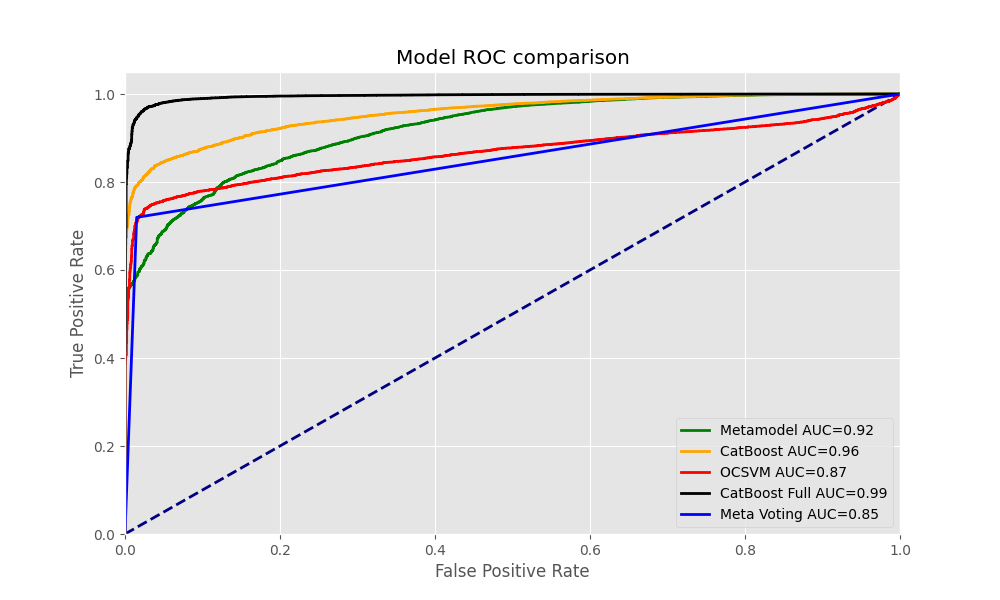

##################
Metamodel ROC threshold: 0.5
Metamodel classification report:
              precision    recall  f1-score   support

           0       0.92      0.14      0.25      2788
           1       0.92      1.00      0.96     25915

    accuracy                           0.92     28703
   macro avg       0.92      0.57      0.60     28703
weighted avg       0.92      0.92      0.89     28703

Metamodel confusion matrix:
[[  402  2386]
 [   36 25879]]
##################
CatBoost ROC threshold: 0.5
CatBoost classification report:
              precision    recall  f1-score   support

           0       0.70      0.50      0.59      2788
           1       0.95      0.98      0.96     25915

    accuracy                           0.93     28703
   macro avg       0.82      0.74      0.77     28703
weighted avg       0.92      0.93      0.93     28703

CatBoost confusion matrix:
[[ 1401  1387]
 [  597 25318]]
##################
OCSVM ROC threshold: 0.5
OCSVM classification repo

In [58]:
multi_model_perf(y_test, [test_data['meta_y_pred'], test_data['cat_cl_pred'], test_data['ocsvm_pred'],
                       test_data['full_y_pred'], test_data['meta_voting_pred_label']], 
              ['Metamodel','CatBoost', 'OCSVM',
               'CatBoost Full', 'Meta Voting'], report_threshold=[0.5,0.5,0.5,0.5,0.5])

In [42]:
print('Hardest rendition types:')
test_data['full_y_pred_lab'] = test_data['full_y_pred']>0.9
test_data[test_data.full_y_pred_lab!=test_data.target].groupby('rendition').rendition.count().sort_values().tail(15)

Hardest rendition types:


rendition
360p_low_bitrate_4          13
144p_black_and_white        13
240p_low_bitrate_4          17
240p_watermark              17
1080p_low_bitrate_4         21
144p                        21
144p_watermark              23
1080p_watermark-345x114     23
480p_low_bitrate_4          36
720p_low_bitrate_4          41
720p_watermark-345x114      46
480p_watermark-345x114      72
360p_watermark-345x114      90
240p_watermark-345x114     109
144p_watermark-345x114     174
Name: rendition, dtype: int64

In [43]:
print('Feature importance:')
importance = catboost_full.get_feature_importance(prettified=True)
importance['Feature Name']=np.array(FULL_FEATURES)[importance['Feature Id'].values.astype(np.int32)]
importance

Feature importance:


,Feature Id,Importances,Feature Name
0,4,28.359410,size_dimension_ratio
1,3,21.973176,temporal_threshold_gaussian_difference-mean
2,2,13.857548,temporal_gaussian_difference-mean
3,1,13.653583,temporal_gaussian_mse-mean
4,0,12.867430,temporal_ssim-mean
5,5,9.288852,temporal_dct-mean
